# kaggle 참가

참가할 kaggle의 주소는 아래와 같습니다. 
[링크](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)





참고한 Kaggle Notebooks는 아래와 같습니다.


https://www.kaggle.com/tmheo74/geo-data-eda-and-feature-engineering              
https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline                        
https://www.kaggle.com/rangmar/25th-solution-xgb-lightgbm-ensemble                    

## 시작하기 전에...

사용할 library들을 conda를 통해 설치합니다.
``` terminal 
$ conda install -c conda-forge xgboost
$ conda install -c conda-forge lightgbm
$ conda install -c conda-forge missingno
사이킷런 (scikit-learn) 버전을 0.23.0로 맞춰줍니다.
```

data와 결과를 저장할 폴더를 만들었습니다.


``` terminal
$ mkdir -p ~/aiffel/kaggle_kakr_housing
```


그후 데이터를 받은 후 경로에 풀어주도록합니다.

``` terminal 
$ mv kaggle-kakr-housing-data.zip ~/aiffel/kaggle_kakr_housing
$ cd ~/aiffel/kaggle_kakr_housing
$ unzip kaggle-kakr-housing-data.zip
```


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

데이터 전처리에는 시각화가 필수입니다. 시각화 그래프를 나타낼수있도록 matplotlib inline을 해줍시다.      
필요한 library들을 뽑아줍니다.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
print('얍💢')

얍💢


사용할 함수들을 불러옵니다. 

In [3]:
def haversine_array(lat2, lng2):
    lat1, lng1 = 47.63, -122.22
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# haversine_array는 원형의 지구에서 위경도를 가지고 거리를 계산해주는 함수입니다.
#거리의 기준이 되는 위경도를 47.63, -122.22로 설정하였습니다. 

def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    diffs = np.expm1(predictions) - np.expm1(labels)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('rmse_exp', np.sqrt(avg))

#np.exp1m()은 각 원소 x마다 exp(x)-1의 값을 반환해 주는 함수입니다. 그후 square root를 취한후 평균을 계산하여 rmse_exp를 계산합니다.  

def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 6), grid_model.best_params_))
    return grid_model.best_estimator_

#GridSerchCV를 통해서 최적의 param을 찾는 함수입니다. 기준은 rmse를 사용합니다. 


def zipcode_groupby(train, test, group_col, colname, agg_method) :
    new_colname = 'price_per'+'_'+colname
    #new_colname2 = colname+'mean'
    
    train[new_colname] = train['price']/train[colname]
    price_per_temp = train.groupby([group_col])[new_colname].agg(agg_method)
    price_per_temp.columns = ['{}_{}'.format(new_colname, m) for m in agg_method]
    price_per_temp = price_per_temp.reset_index()
    #price_per_temp.rename(columns={'mean':new_colname2}, inplace=True)
    train = pd.merge(train, price_per_temp, how='left', on=group_col)
    test = pd.merge(test, price_per_temp, how='left', on=group_col)
    
    del train[new_colname]
    
    return train, test


def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()




def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t

def category_feature_distribution(train, col, target='price'):
    fig, ax = plt.subplots(1, 2, figsize=(16,4))
    
    for c in sorted(train[col].unique()):
        sns.distplot(train.loc[train[col]==c, target], ax=ax[0])
    ax[0].legend(sorted(train[col].unique()))
    ax[0].set_title(f'{col} {target} distribution')

    sns.boxplot(x=col, y=target, data=train, ax=ax[1])
    ax[1].set_title(f'{col} vs {target}')
    
    plt.show()
    
#category_fearure의 distribution을 확인하는 함수입니ㅏㄷ. 
    
def haversine_array_new(lat1_raw, lng1_raw, lat2, lng2):
    lat1, lng1 = lat1_raw, lng1_raw
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


#  원형의 지구에서 위경도를 가지고 거리를 계산해주는 함수입니다.
#거리의 기준이 되는 위경도를 바로바로 설정할수있게 설정했습니다. 

def haversine_array_low(lat2, lng2):
    lat1, lng1 = 47.382, -122.247
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# haversine_array는 원형의 지구에서 위경도를 가지고 거리를 계산해주는 함수입니다.
#거리의 기준이 되는 위경도를 47.63, -122.22로 설정하였습니다. 

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)

/home/ssac4/aiffel/kaggle_kakr_housing/data/train.csv
/home/ssac4/aiffel/kaggle_kakr_housing/data/test.csv


## 데이터 전처리


### 데이터 불러오기 
데이터를 불러와 그 형태를 살펴봅니다. 

In [5]:

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
train_raw = train

print('얍💢')
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

print(train.shape[0]/(test.shape[0]+train.shape[0]))


얍💢
train data dim : (15035, 21)
sub data dim : (6468, 20)
0.699204762126215


약 train data가 70%, test(sub) data가 30%를 차지하는 데이터 셋임을 확인할 수있었습니다.           
sub data가 한차원 적은것은
label값이 없어서 그런것입니다. 

## 일시적으로 train에서 y 제거 

In [6]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### train 데이터와 테스트 데이터 합치기

전체 데이터를 살펴보기 위해서 일단 train data와 테스트 데이터를 합쳐봅니다.

In [7]:
train_len = len(train)
data = pd.merge(train, test, how='outer')


print(len(data))
data.head()


21503


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


다시 분리할때를 대비해서 train data의 length도 미리 지정해놓습니다.

### missing data 확인

<AxesSubplot:>

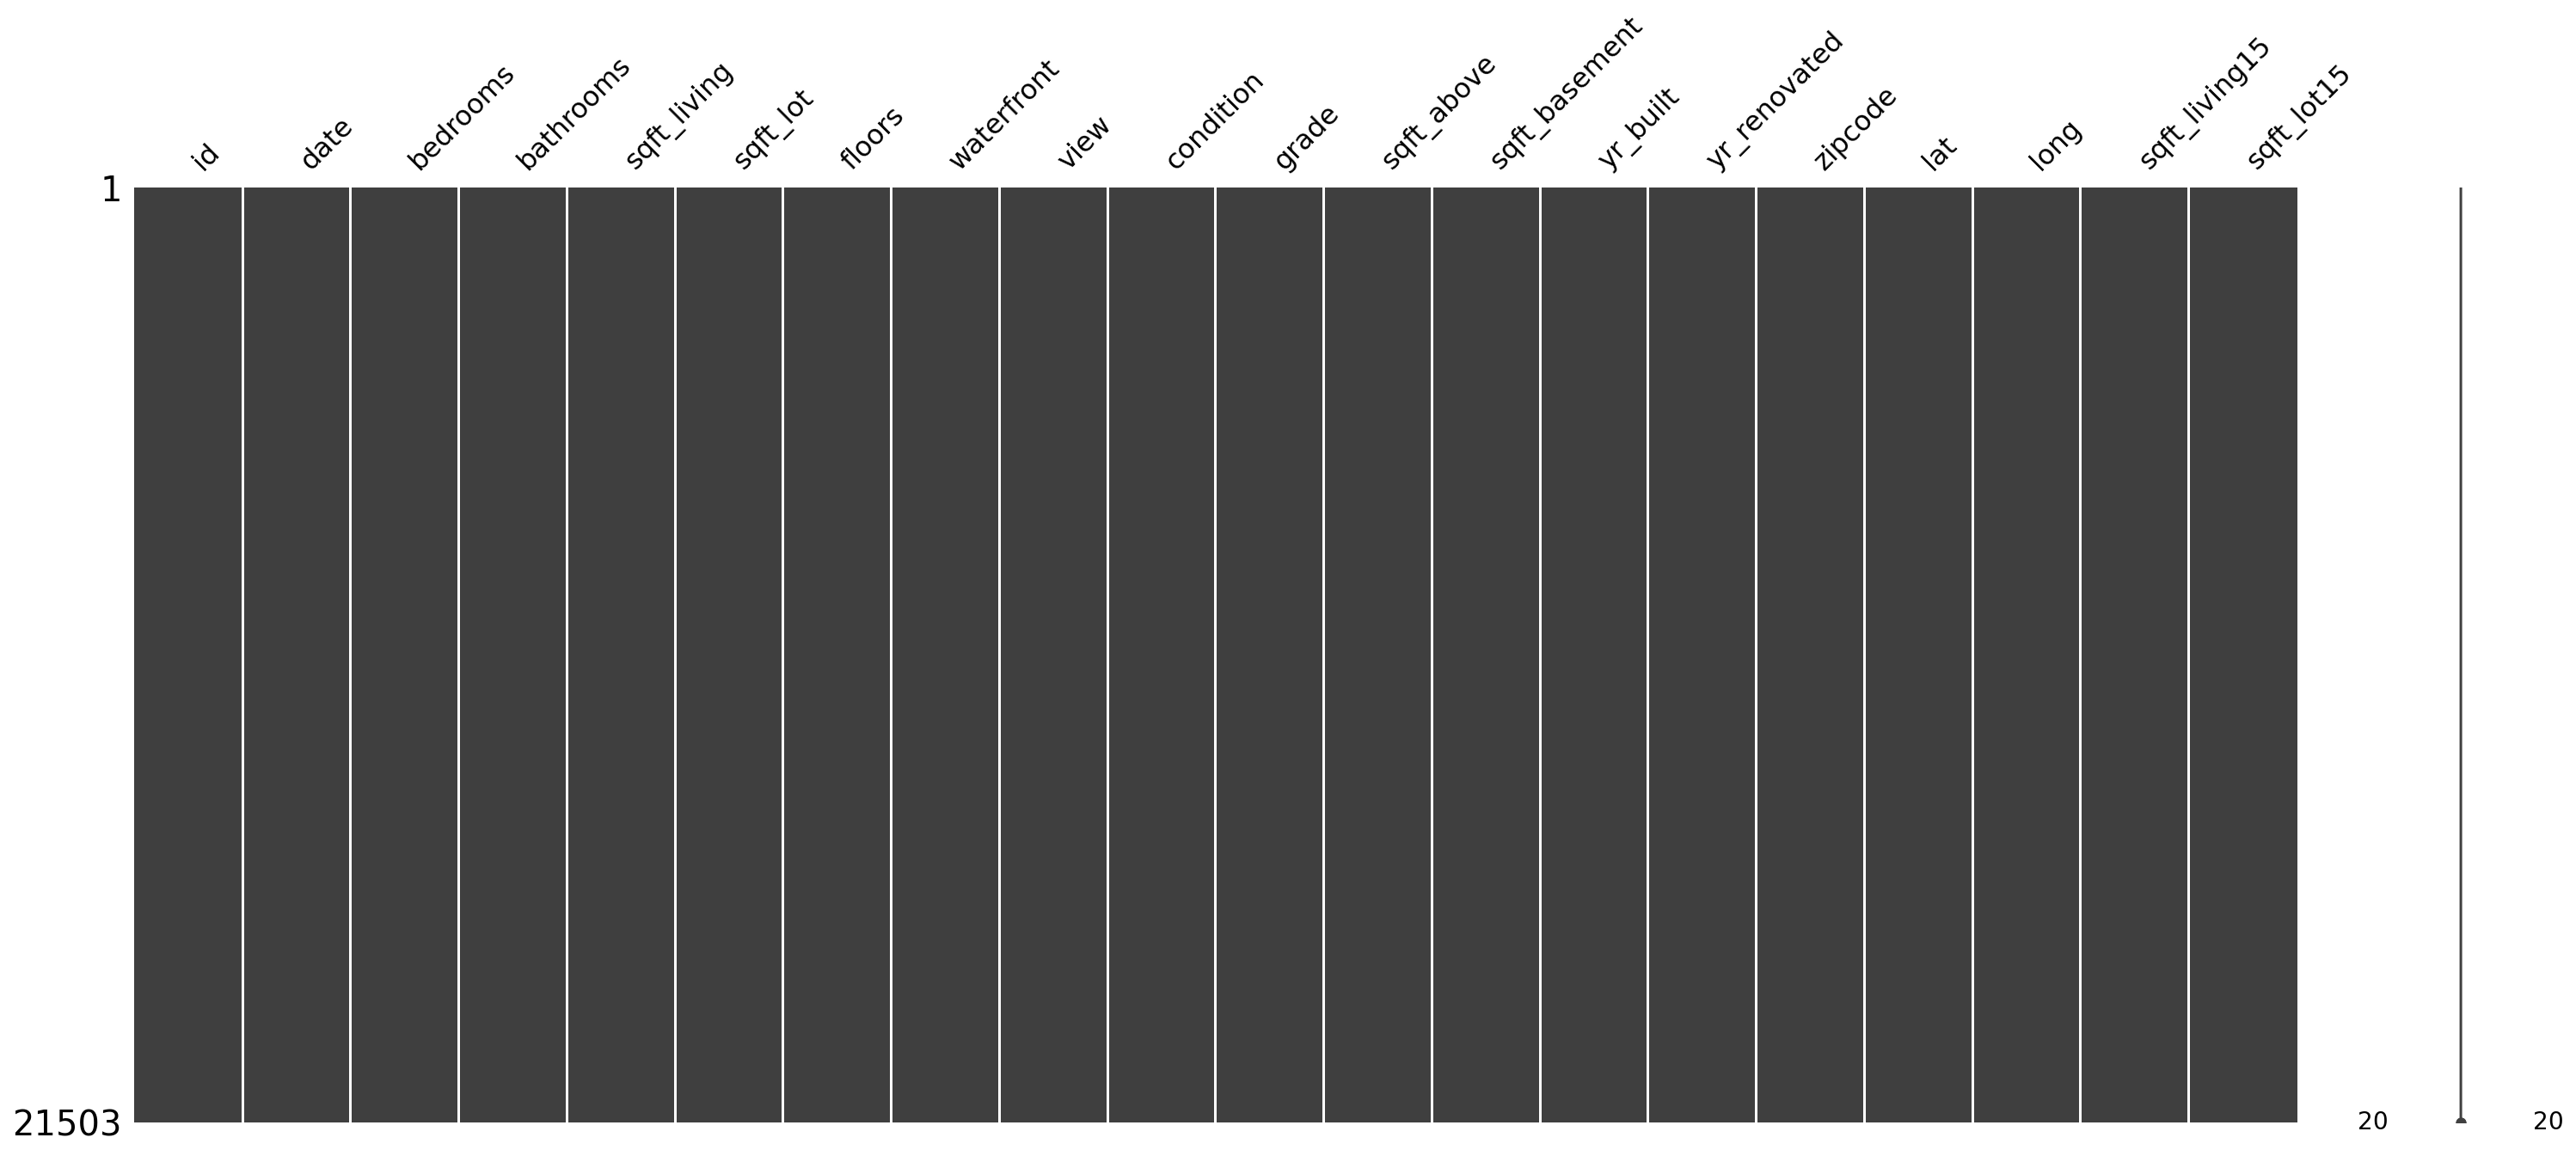

In [8]:
msno.matrix(data)



missingno library의 matrix명령어를 통해 na값이 존재하는 구간을 시각화할수 있습니다.                
na 값 부분이 존재하지 않음을 확인할 수 있습니다.

아래는 직접 있는 부분을 찾는 코드입니다.

In [9]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 불필요 데이터 정리 
분석에 직접적으로 필요하지는 않는 id컬럼을 제거합니다. 
또한 나중에 제출할때를 대비해서 sub_id 변수에 id를 저장해놓습니다. 


In [10]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


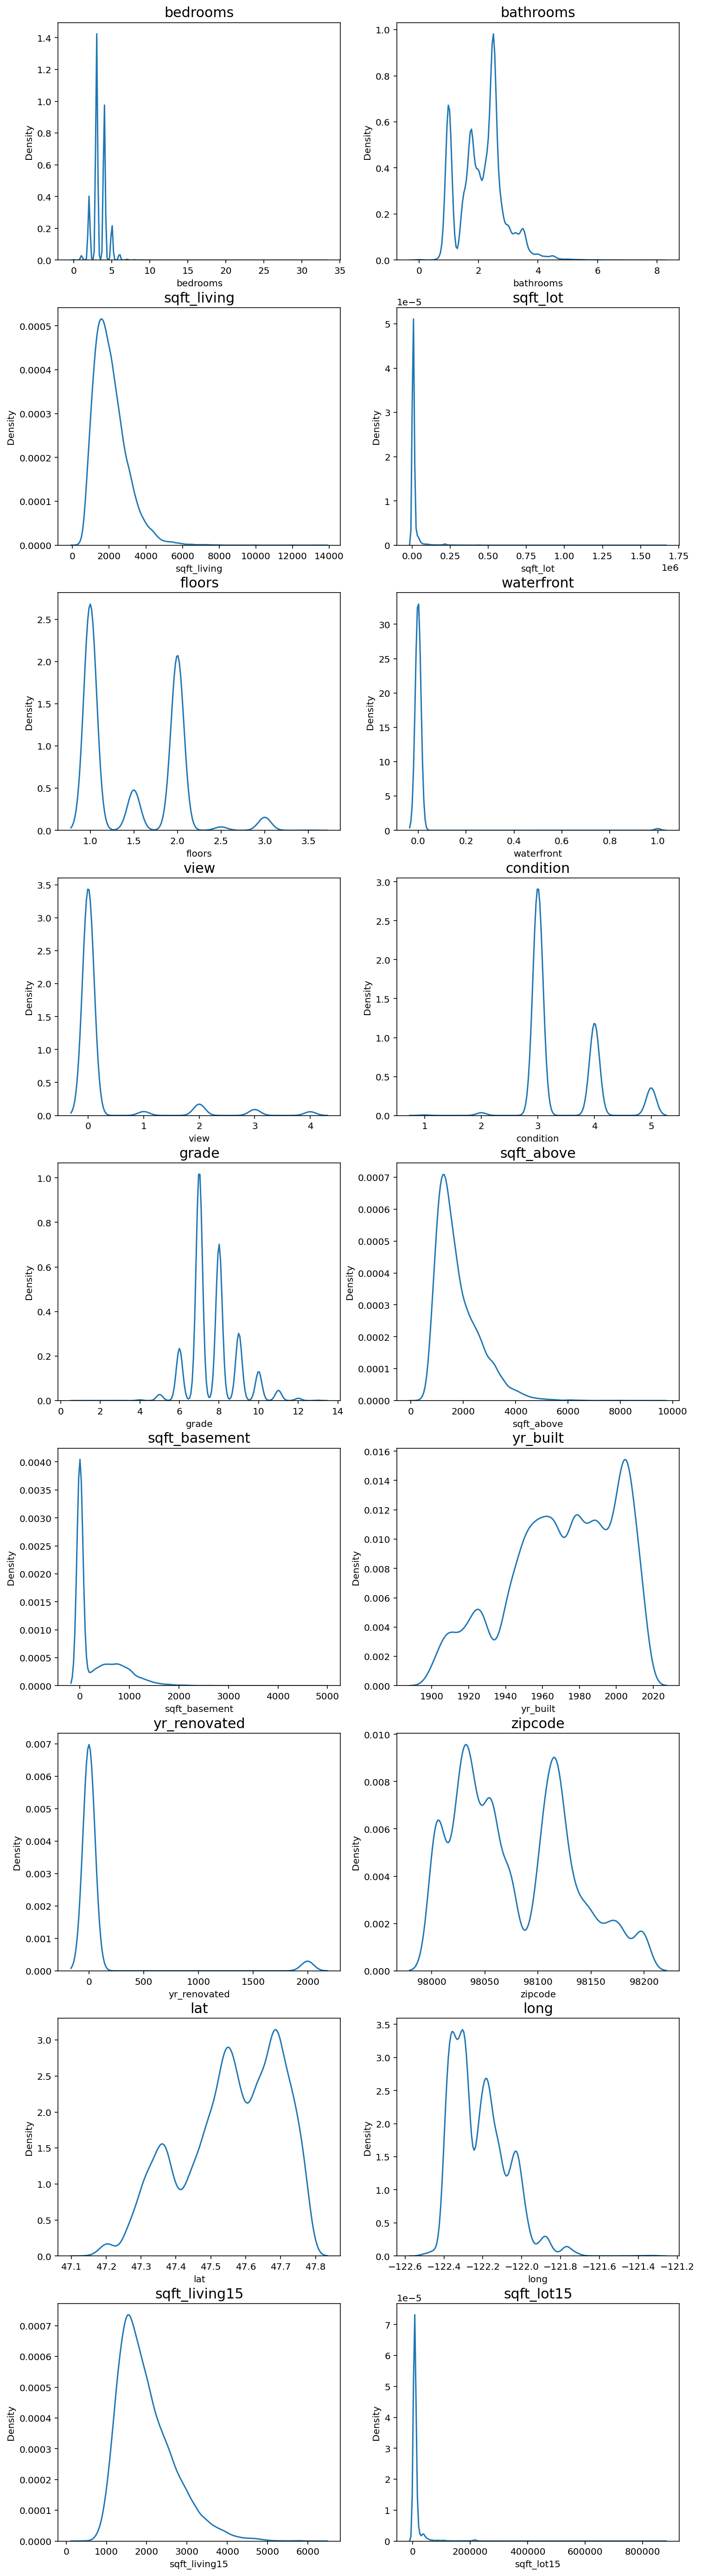

In [11]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break


위 그래프 중에서는 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement,sqft_lot15 변수가              
한쪽으로 치우친 경향을 보이는 것을  확인했습니다.

이 치우친 변수들은 log(1+x) 스케일로 변환하여 정규화 시키도록 하겠습니다.

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')


얍💢


변환이후의 분포를 다시 살펴보겠습니다.

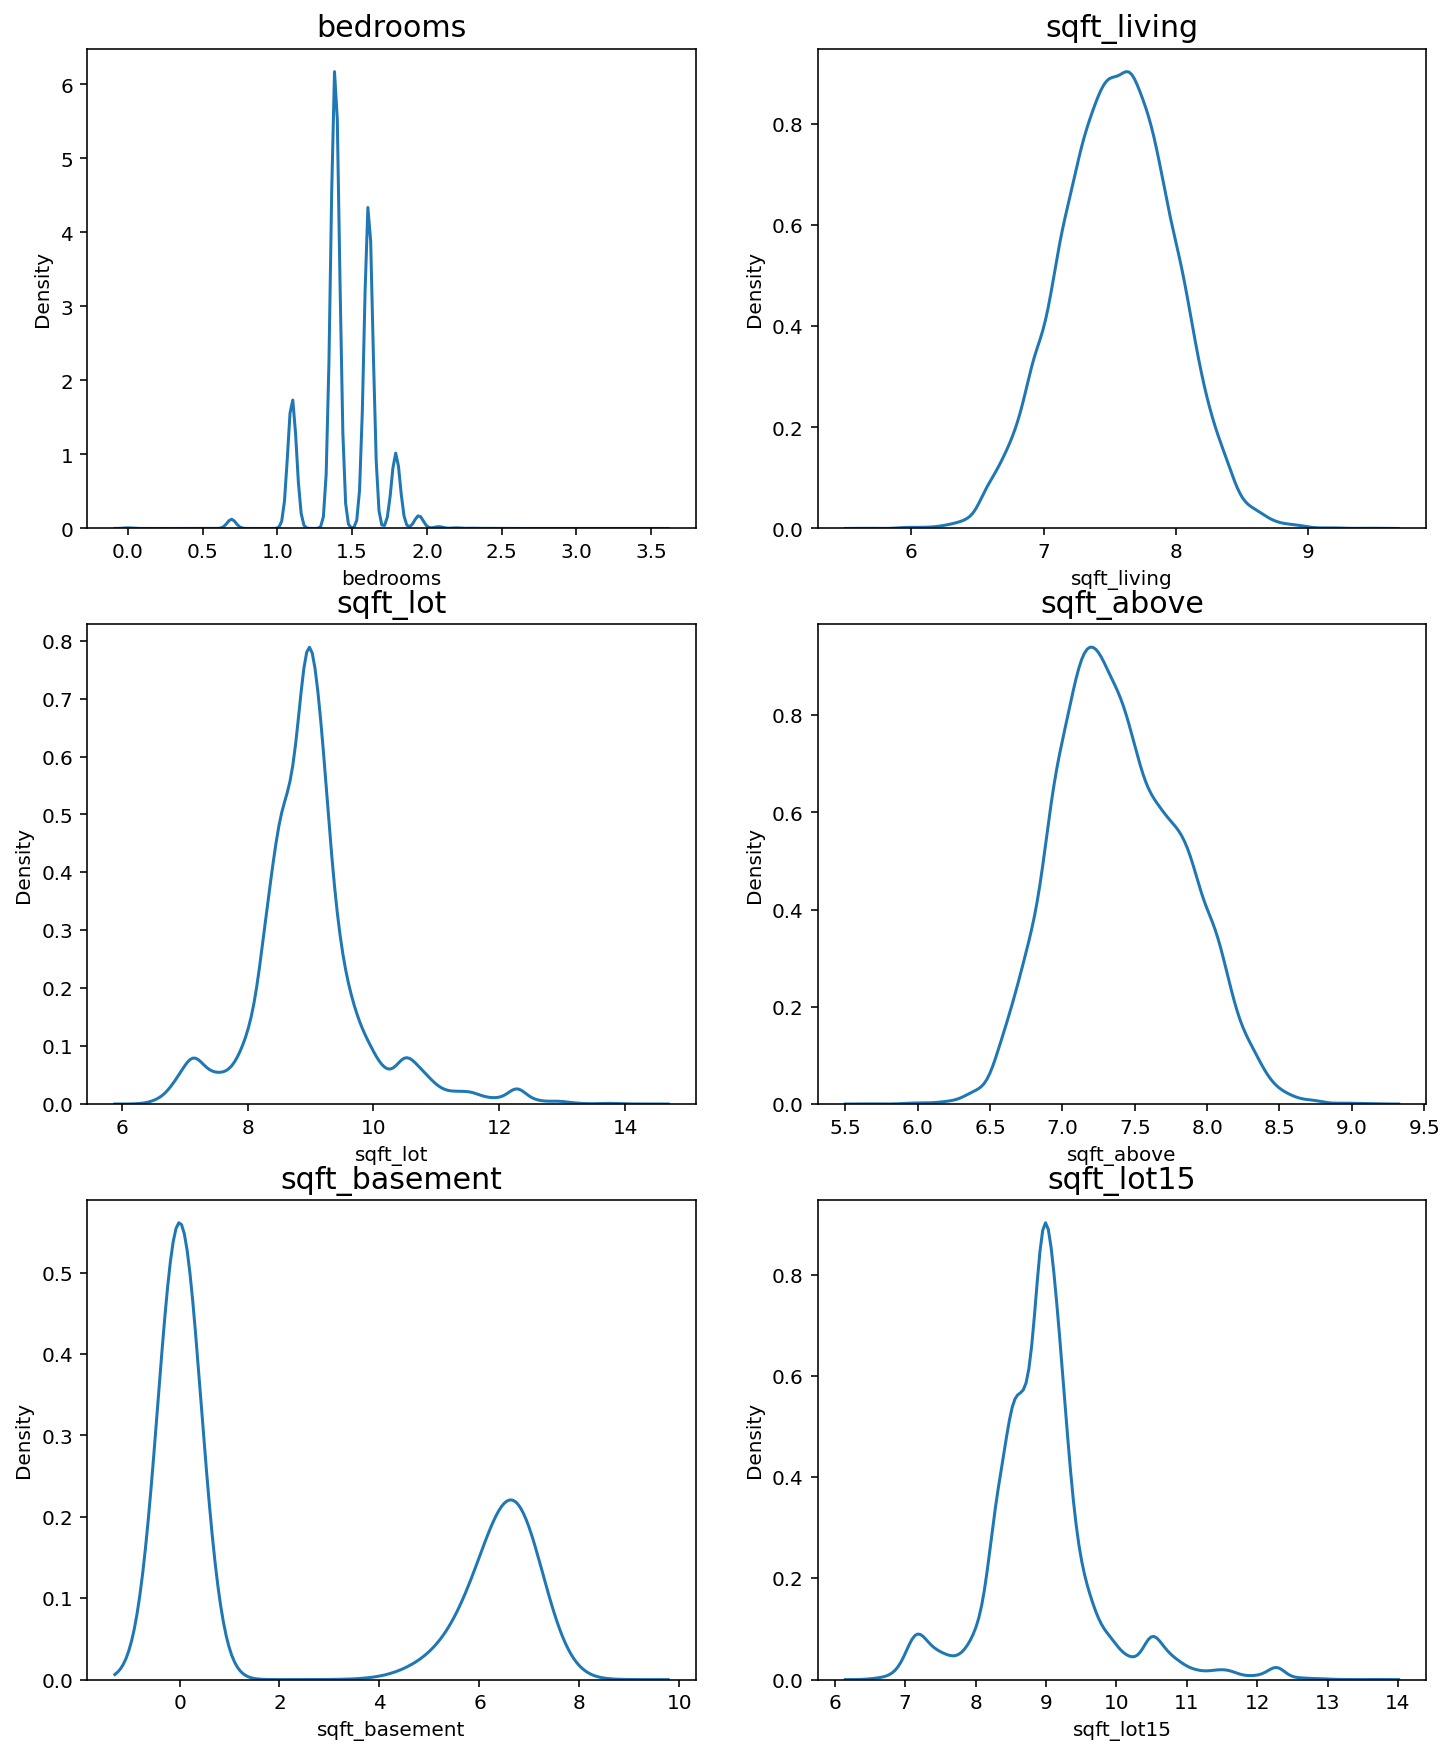

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 6:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

log하나 씌운것만으로도 괜찮게 변형된것을 확인 할 수 있었습니다.

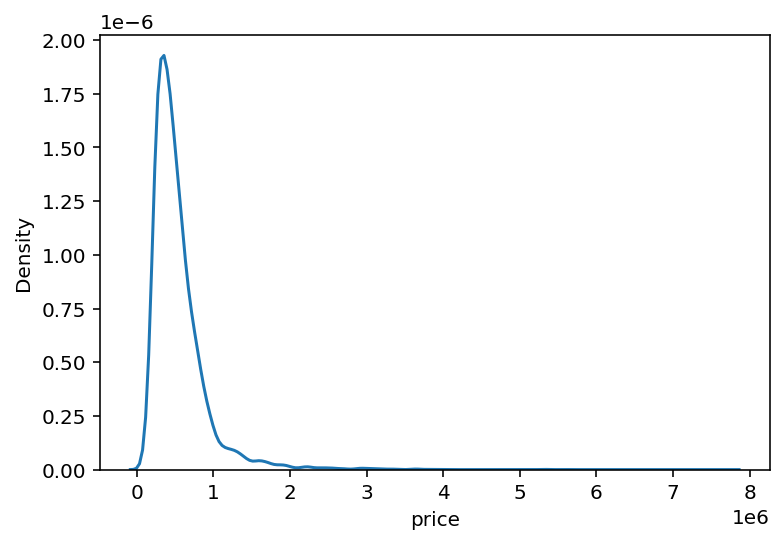

In [14]:
sns.kdeplot(y)
plt.show()

y 역시 소수의 큰값들이 존재해서 꼬리가 존재하는 것을 확인할 수있습니다.
하지만 아직 변수 엔지니어링을 끝내지않았기때문에 일단 두겠습니다. 

In [15]:
# y = np.log1p(y)

# sns.kdeplot(y)
# plt.show()

이제 통합했던 데이터를 다시 분리합니다. 

In [16]:
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  object 
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6468 entries, 15035 to 21502
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           6468 non-null   object 
 1   bedrooms       6468 non-null   float64
 2   bathrooms      6468 non-null   float64
 3   sqft_living    6468 non-null   float64
 4   sqft_lot       6468 non-null   float64
 5   floors         6468 non-null   float64
 6   waterfront     6468 non-null   int64  
 7   view           6468 non-null   int64  
 8   condition      6468 non-null   int64  
 9   grade          6468 non-null   int64  
 10  sqft_above     6468 non-null   float64
 11  sqft_basement  6468 non-null   float64
 12  yr_built       6468 non-null   int64  
 13  yr_renovated   6468 non-null   int64  
 14  zipcode        6468 non-null   int64  
 15  lat            6468 non-null   float64
 16  long           6468 non-null   float64
 17  sqft_living15  6468 non-null   int64  
 18  sqf

## GEO DATA 시각화
집값데이터다 보니 위치도 한번 시각화 해보겠습니다.

In [19]:
geo_train = train
geo_test = test 

(15035, 25)


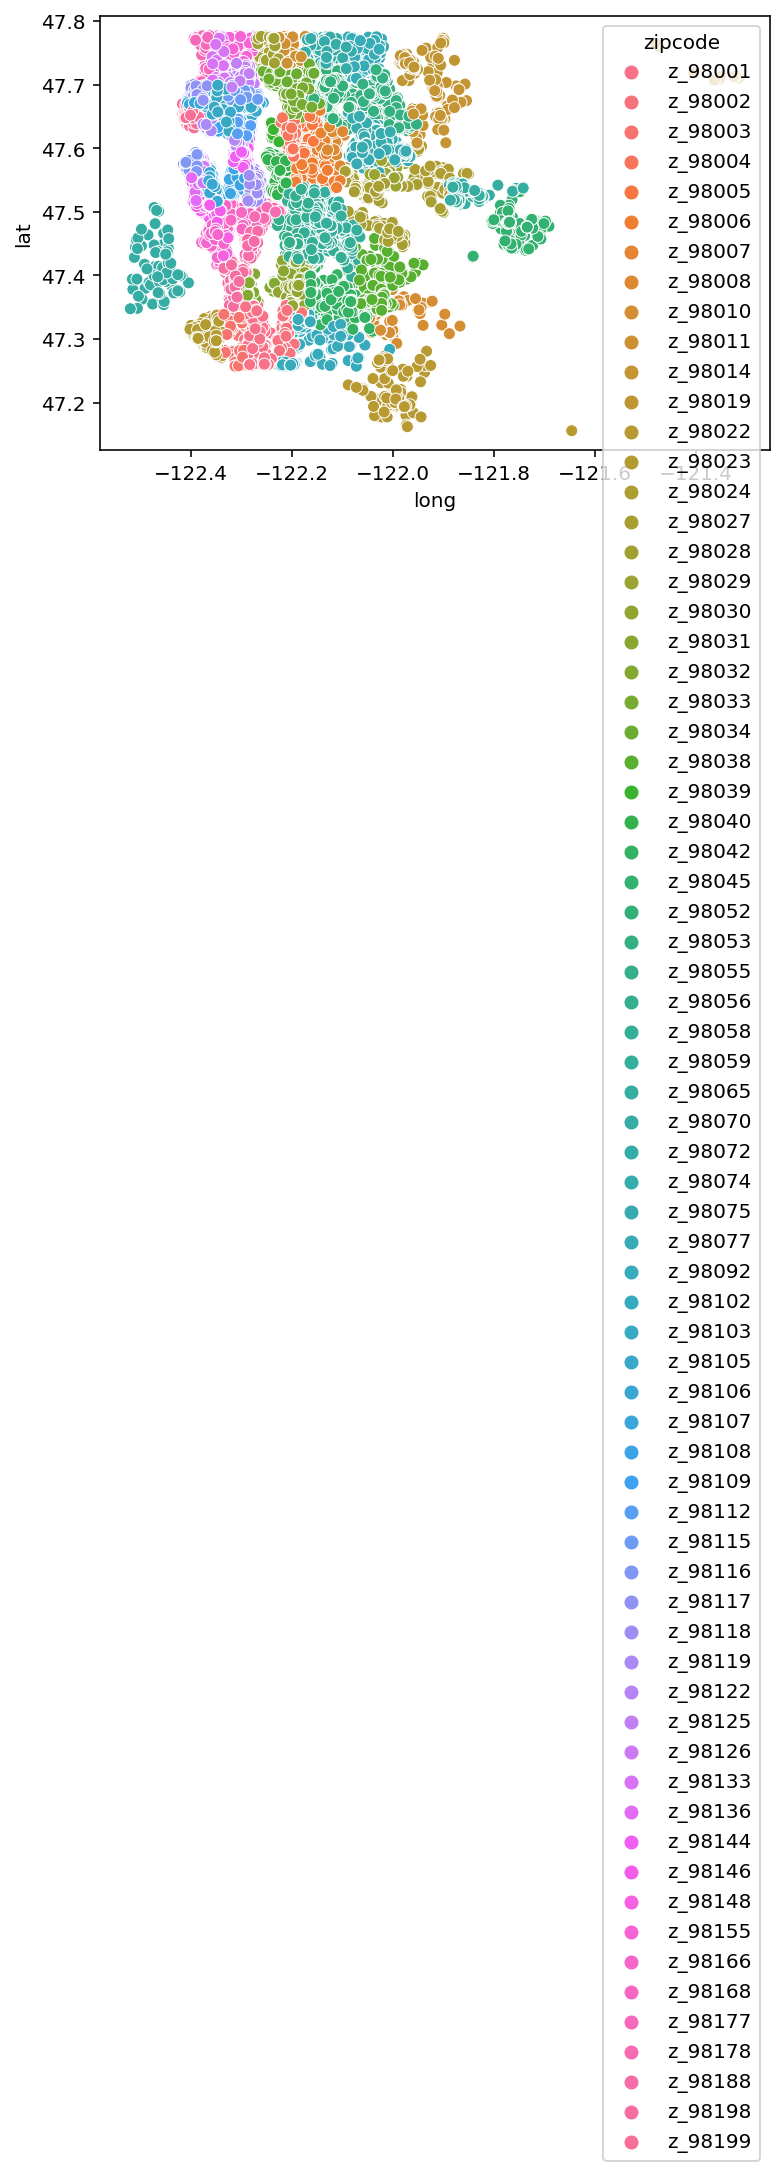

In [20]:
geo_train.zipcode = geo_train.zipcode.astype(str)

geo_train['zipcode-3'] = 'z_' + geo_train['zipcode'].str[2:3]
geo_train['zipcode-4'] = 'z_' + geo_train['zipcode'].str[3:4]
geo_train['zipcode-5'] = 'z_' + geo_train['zipcode'].str[4:5]
geo_train['zipcode-34'] = 'z_' + geo_train['zipcode'].str[2:4]
geo_train['zipcode-45'] = 'z_' + geo_train['zipcode'].str[3:5]
geo_train['zipcode-35'] = 'z_' + geo_train['zipcode'].str[2:3] + geo_train['zipcode'].str[4:5]

print(geo_train.shape)
geo_train.head()

geo_train['zipcode'] = 'z_' + geo_train['zipcode']
sns.scatterplot(x='long', y='lat', hue='zipcode', hue_order=np.sort(geo_train['zipcode'].unique()), data=geo_train);

train 데이터들의 zipcode 위치 시각화입니다. 

(6468, 25)


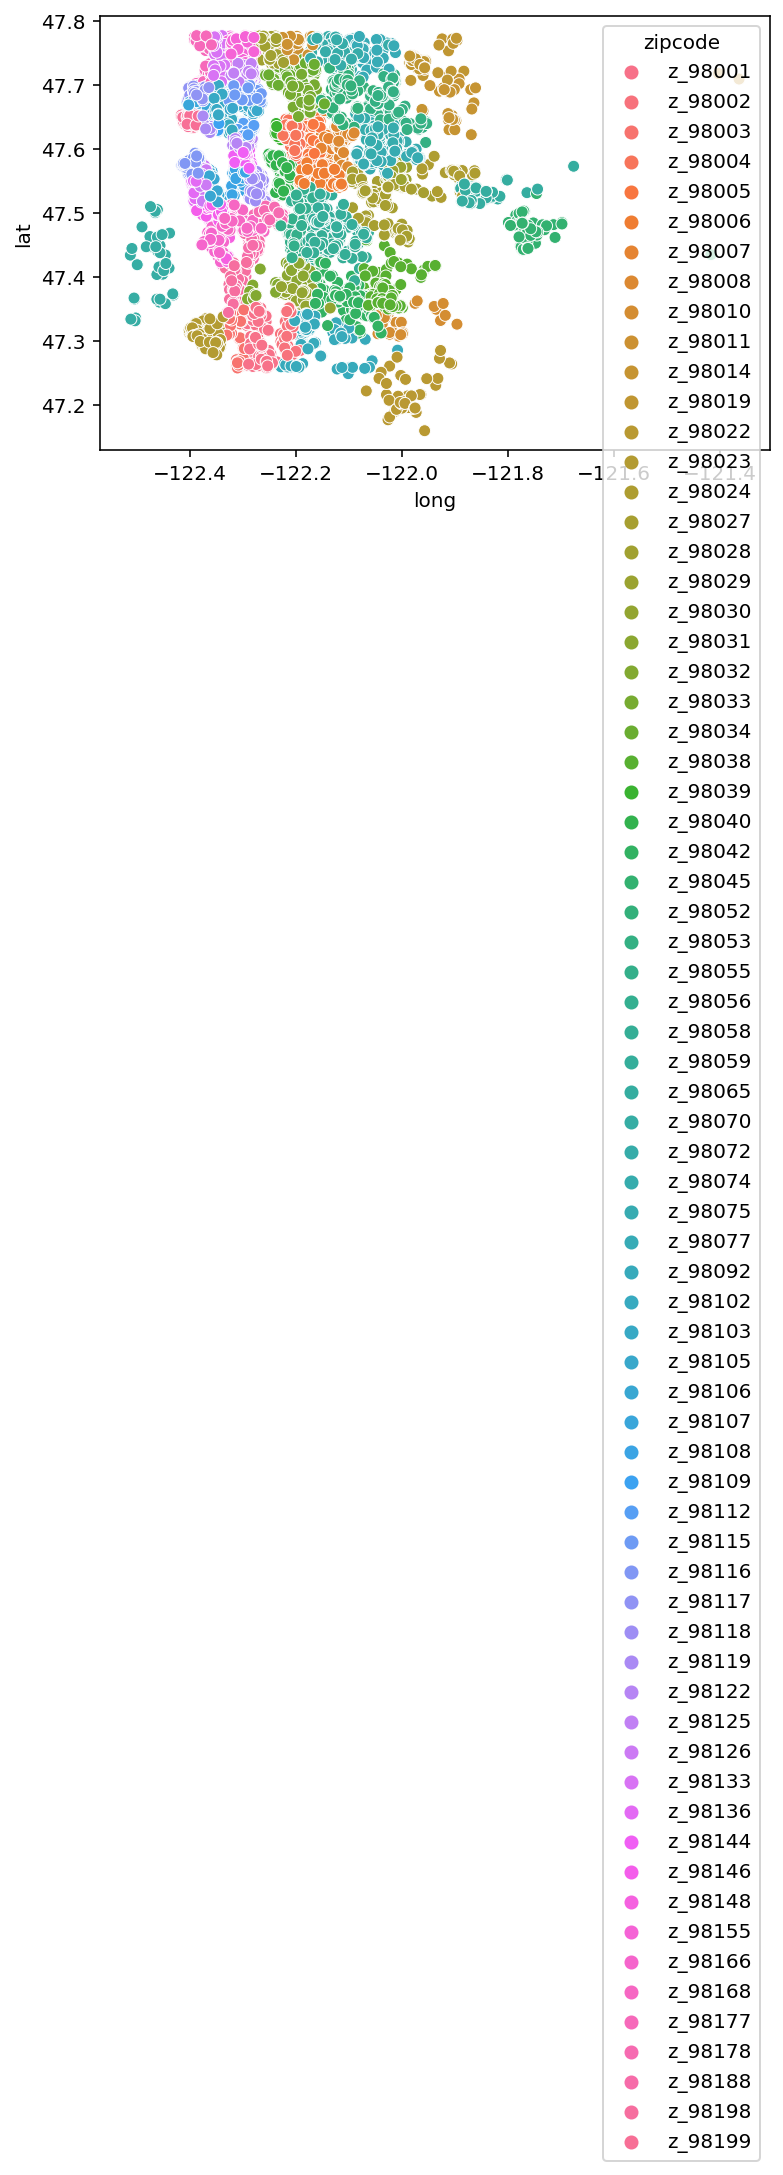

In [21]:
geo_test.zipcode = geo_test.zipcode.astype(str)

geo_test['zipcode-3'] = 'z_' + geo_test['zipcode'].str[2:3]
geo_test['zipcode-4'] = 'z_' + geo_test['zipcode'].str[3:4]
geo_test['zipcode-5'] = 'z_' + geo_test['zipcode'].str[4:5]
geo_test['zipcode-34'] = 'z_' + geo_test['zipcode'].str[2:4]
geo_test['zipcode-45'] = 'z_' + geo_test['zipcode'].str[3:5]
geo_test['zipcode-35'] = 'z_' + geo_test['zipcode'].str[2:3] + geo_test['zipcode'].str[4:5]

print(geo_test.shape)
geo_test.head()

geo_test['zipcode'] = 'z_' + geo_test['zipcode']
sns.scatterplot(x='long', y='lat', hue='zipcode', hue_order=np.sort(geo_test['zipcode'].unique()), data=geo_test);

test data 위치입니다. 

## 피쳐링 엔지니어링 
이웃 중 가장 가까운 곳과의 거리

자기 자신을 제외한 나머지 집들과의 haver 거리 중 최소값             
**즉 가장 가까운 이웃과의 거리**          
을 계산한 min_haver를 추가합니다.  

In [22]:
data['min_haver'] = np.nan
for i in range(len(data)) :
    temp_lat, temp_lng = data[['lat', 'long']].loc[i,'lat'], data[['lat', 'long']].loc[i,'long']
    temp_all_df = data.drop([i], 0)
    temp_coord_df = haversine_array_new(temp_lat, temp_lng, temp_all_df['lat'], temp_all_df['long'])
    temp_min = temp_coord_df.min()
    data.loc[i,'min_haver'] = temp_min  

zipcode를 뽑아낸후 LabelEncoder를 통해 encoding합니다. 
이때 zipcode 중 첫번째 두번째인 98을 제외한 3,4번째 숫자를 뽑아 zip_12로 설정했습니다. 

In [23]:
######## zipcode 라벨링
train = data.iloc[:train_len,:]
test = data.iloc[train_len:,:]

for df in [train, test] :
    #df['zip_1'] = df['zipcode'].apply(lambda x : str(x)[2]).astype(int)
    df['zip_12'] = df['zipcode'].apply(lambda x : str(x)[2:4]).astype(int)
    #df['zip_2'] = df['zipcode'].apply(lambda x : str(x)[3]).astype(int)
    #df['zip_23'] = df['zipcode'].apply(lambda x : str(x)[3:5]).astype(int)
    #df['zip_3'] = df['zipcode'].apply(lambda x : str(x)[4]).astype(int)

le = LabelEncoder()

le.fit(train['zipcode'])
le.fit(test['zipcode'])

train['zipcode'] = le.transform(train['zipcode'])
test['zipcode'] = le.transform(test['zipcode'])

총 주거 면적 변수를 추가합니다. 

In [24]:
train['sqft_total_size'] = train['sqft_above'] + train['sqft_basement'] # 총 주거 면적    
test['sqft_total_size'] = test['sqft_above'] + test['sqft_basement']

거주 구역 당 가격을 변수를 만든 후  zipcode를 통해 groping합니다.  
그후 zipcode당 price_per_land_are의 mean, std, count를 계산해서 변수로 추가합니다. 

In [25]:
train['price'] = y 

아까 빼놨던 y를 다시  추가합니다. y를 활용한 변수를 넣기 위함입니다.

In [26]:
####### zipcode_groupby 단가 변수 생성
train['price_per_land_area'] = train['price'] / (train['sqft_living'])
price_per_ft = train.groupby(['zipcode'])['price_per_land_area'].agg({'mean', 'std', 'count'}).reset_index()
train = pd.merge(train, price_per_ft, how='left', on='zipcode')
test = pd.merge(test, price_per_ft, how='left', on='zipcode')
del train['price_per_land_area']

In [27]:
####### train, test set 지정
train_raw = train

X_train = train.drop(['price'], 1)
y_train = train['price']
y_train = np.log1p(y_train)
X_test = test

여기서 y에 log1p를 취해줍니다. 

위치는 kmeans를 통해 120개의 군집으로 나누어줍니다. 그리고 변수를 추가합니다.

In [28]:

####### KMeans Clustering
km_n = 120
km = KMeans(n_clusters=km_n, random_state=2019)
km.fit(X_train[['lat', 'long']])#

######## 이외 Feature Engineering
for df in [X_train, X_test]:
    df['date(new)'] = df['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400) # 날짜 줄 세우기
    df['how_old'] = df['date'].apply(lambda x: x[:4]).astype(int) - df[['yr_built', 'yr_renovated']].max(axis=1) # 얼마나 됐는지 연식
    df['yr_built'] = df['yr_built'] - 1900 # 건축년도 1900년도로부터 얼마나 됐는지 
    
    # sqft 관련
    df['sqft_diff'] = df['sqft_living15'] - df['sqft_living']
    df['sqft_living_lot_diff'] = df['sqft_lot'] - df['sqft_living']
    #df['sqft_living_lot_div'] = df['sqft_living'] / df['sqft_lot']
    del df['sqft_lot15'], df['yr_renovated'], df['sqft_lot'],df['date']#, df['waterfront']#, df['view'], df['condition']
    
    #df['sqft_living_all'] = df['sqft_living'] + df['sqft_living15']
    #df['living_div'] = df['sqft_living15'] / df['sqft_living_all']    
    
    # 방 관련
    df['sqft_bedrooms'] = df['sqft_total_size'] / (df['bedrooms'] + 1) # 방하나당 면적 : bedrooms가 0인 자료 꽤 있음 
    
    
    # KMeans 클러스터링
    km_col_name = 'km'+ '_' + str(km_n)
    df[km_col_name] = km.predict(df[['lat', 'long']])
    
    # 레벨 관련
    df['sum_level'] = df['grade'] + df['view'] + df['condition'] # 등급 총합
    df['multi_level'] = df['grade'] * (df['view']+1) * df['condition']
    
    df['condition_2'] = df['condition'].apply(lambda x : 0 if x < 3 else x)
    df['sum_level_2'] = df['view'] + df['condition_2'] + df['grade']
    
    del df['condition_2']
    
    df['low_cond']=df['condition'].apply(lambda x : 0 if x <= 2 else 1)
    df['low_view'] = df['view'].apply(lambda x : 0 if x == 0 else 1)
    df['low_bath'] = df['bathrooms'].apply(lambda x: 0 if x < 1 else 1)
    df['low_bed'] = df['bedrooms'].apply(lambda x : 0 if x ==1 else 1)
    df['low_grade'] = df['grade'].apply(lambda x : 0 if x <= 6 else 1)
    df['low_all'] = (df['low_cond'] + df['low_view']+df['low_bath'] + df['low_bed'] + df['low_grade']) + df['waterfront']
    
    del df['low_cond'], df['low_view'], df['low_bath'], df['low_bed'], df['low_grade']
   
    # 거리 관련
    df['haversine_dist']= haversine_array(df['lat'], df['long']) # 중심가로부터의 거리 (haversine_dist)
    df['haversine_dist_low'] = haversine_array_low(df['lat'], df['long'])
    #df['min_haver_multi'] = df['min_haver'] * df['haversine_dist'] 


    
X_train = X_train.drop([13522, 4123],0)
y_train = y_train.drop([13522, 4123],0)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

print(len(X_train.columns), X_train.columns)
print([item for item in X_train.columns if item not in train_raw.columns])

33 Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'min_haver', 'zip_12',
       'sqft_total_size', 'mean', 'count', 'std', 'date(new)', 'how_old',
       'sqft_diff', 'sqft_living_lot_diff', 'sqft_bedrooms', 'km_120',
       'sum_level', 'multi_level', 'sum_level_2', 'low_all', 'haversine_dist',
       'haversine_dist_low'],
      dtype='object')
['date(new)', 'how_old', 'sqft_diff', 'sqft_living_lot_diff', 'sqft_bedrooms', 'km_120', 'sum_level', 'multi_level', 'sum_level_2', 'low_all', 'haversine_dist', 'haversine_dist_low']


In [29]:
X_train['price'] = y_train
km2 = KMeans(n_clusters=120, random_state=2019)
km2.fit(X_train[['price', 'km_120']])
X_train['km_pre'] = km2.predict(X_train[['price', 'km_120']])
X_train.drop('price', 1, inplace=True)
X_train_km_pre = X_train[['km_120', 'km_pre']].groupby('km_120')['km_pre'].mean().reset_index()
X_test = X_test.merge(X_train_km_pre, how='left', on='km_120')



>**신규 Feature 설명을 요약하자면 아래와 같습니다.**

* date(new), how_old : (DongGyu Lee님의 커널 참고)
* sqft_diff : sqft_living15 - sqft_living
* sqft_living_lot_diff : sqft_lot - sqft_living
* sqft_bedrooms : sqft_living / (sqft_bedrooms + 1)
* sum_level : grade + view + condition
* multi_level : grade * view * condition
* sum_level_2 : view + condition(3미만인 것은 0으로 치환) + grade
* low_all : condtion(2이하는 0, 나머지는 1) + view(0인것은 0 나머지는 1) + bath(1미만은 0 나머지는 1) + bed(1이면 0 나머지는 1) + grade(6이하면 0, 나머지는 1) + waterfront
* haversine_dist : 47.63, -122.22으로부터 거리
* haversine_dist_low : 47.382, -122.247
* km_120 : 120개로 KMeans 클러스터링 lat, long
* km_pre : price와 km_120 KMeans 클러스터링 후 test set에는 merge

multi_level 이후에 나오는 것들에 대해 시각화를 진행하고자 합니다.

> 1) haversine_dist, haversine_dist_low

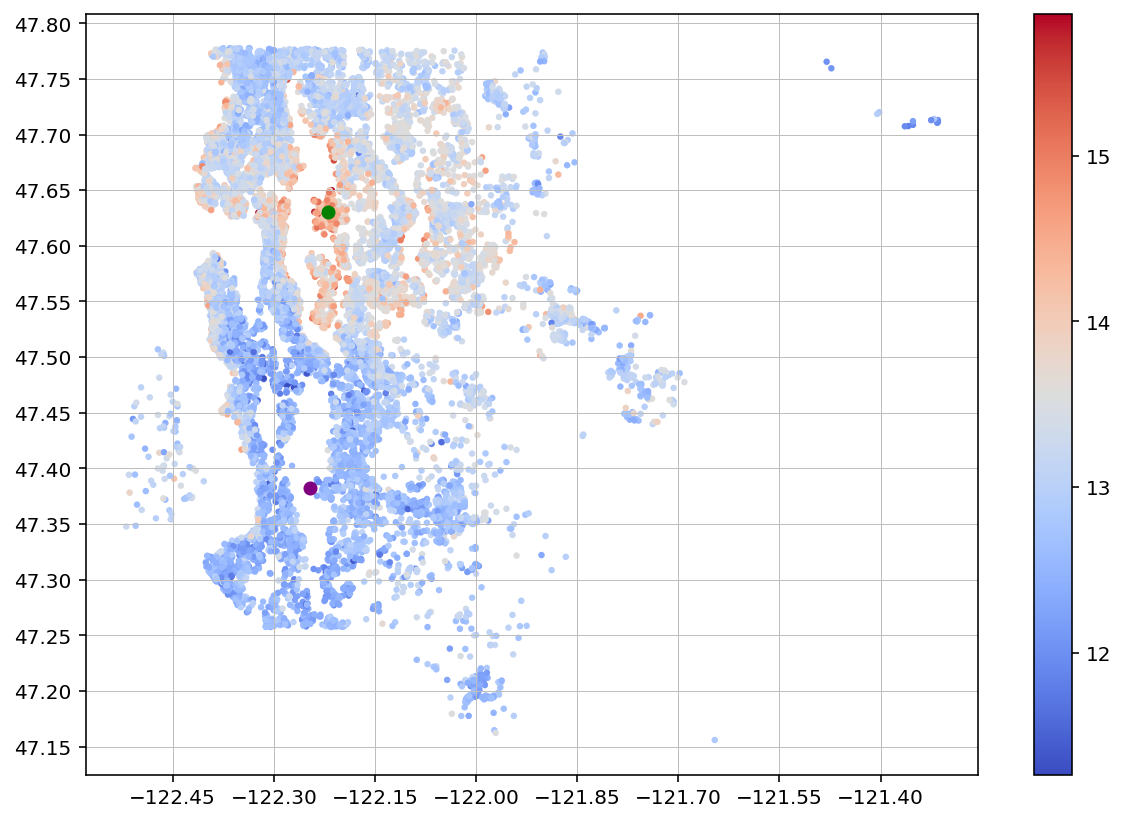

In [30]:
plt.figure(figsize=(10,7))
plt.scatter(train['long'], train['lat'], s=5, c=np.log1p(y), cmap='coolwarm')
plt.yticks(np.arange(47, 47.81, 0.05))
plt.xticks(np.arange(-122.6, -121.2, 0.15))
plt.grid(color='#BDBDBD', linestyle='-', linewidth=0.5)
plt.colorbar()
plt.scatter(-122.22, 47.63, color='green')
plt.scatter(-122.247, 47.382, color='purple')

* 기준점으로 쓴 점들이 초록색과 보라색으로 보입니다. 
* Datagui님께서는 가장 빨간색과 파란색(가격이 높고 낮은) 점이 많이 있는 곳의 중간의 lat, long을 기준점으로 삼았다고합니다.
* 가격이 낮은 곳으로부터 거리는 모르겠지만 가격이 높은 것으로부터 거리는 점수 상승에 많은 기여를 했다고 합니다. 
* 이 커널을 참고하시면 더 많은 정보를 얻으실 수 있습니다. https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

> sum_level_2, low_all

<AxesSubplot:xlabel='low_all', ylabel='price'>

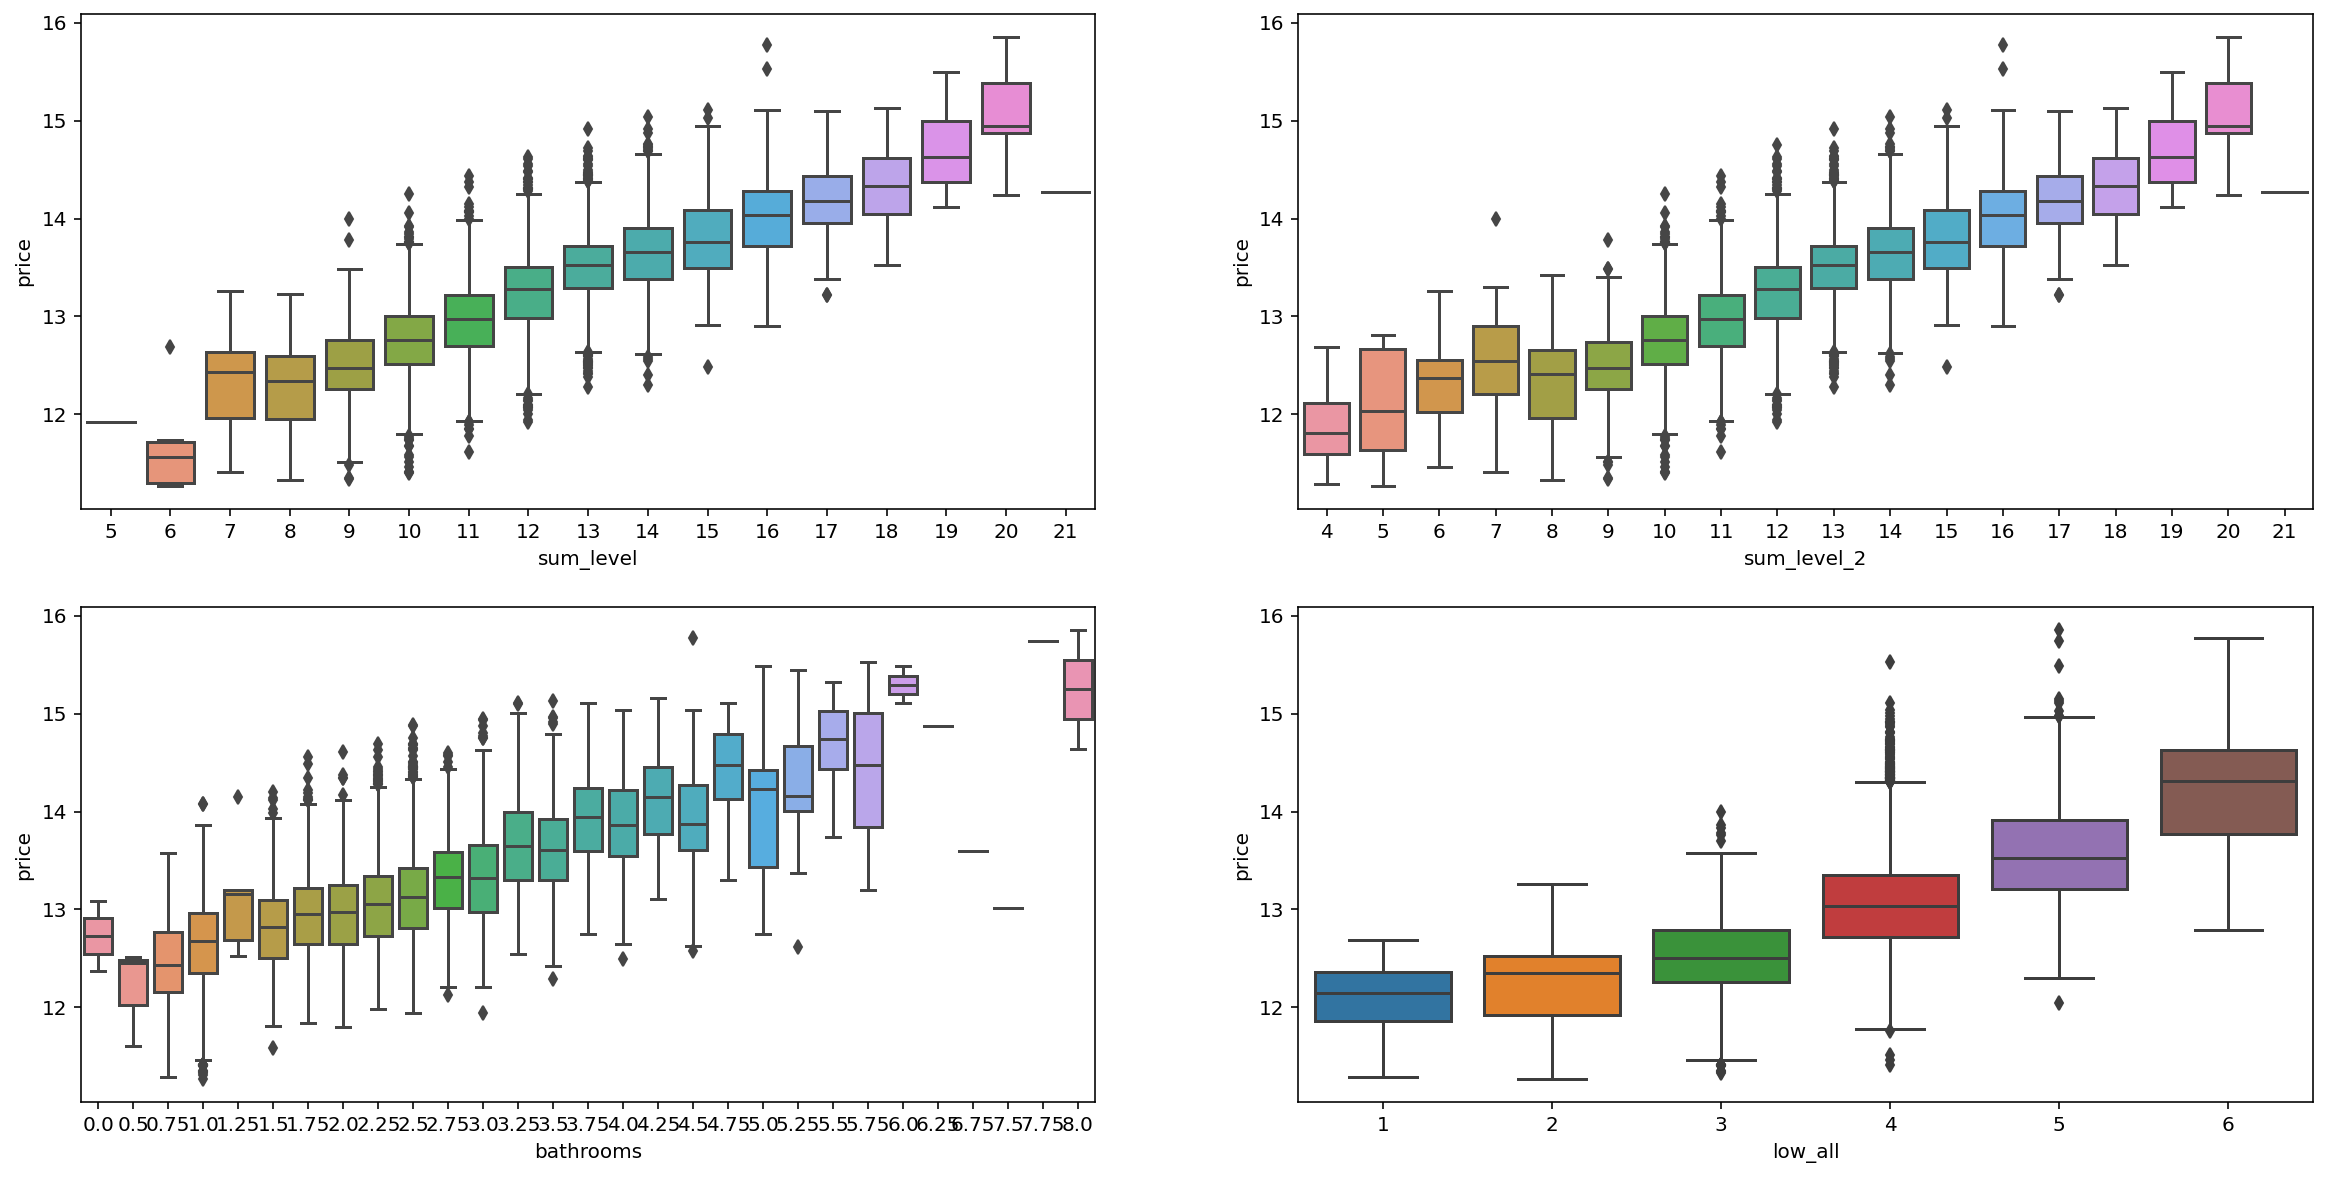

In [31]:
X_train['price'] = y_train
f, ax =  plt.subplots(2,2, figsize=(20, 10))
sns.boxplot(x='sum_level', y='price', data=X_train, ax=ax[0,0])
sns.boxplot(x='sum_level_2', y='price', data=X_train, ax=ax[0,1])
sns.boxplot(x='bathrooms', y='price', data=X_train, ax=ax[1,0])
sns.boxplot(x='low_all', y='price', data=X_train, ax=ax[1,1])

* Datagui님께서는 대회 내내 oof를 통해서 제가 설계하는 모델이 log 변환후 12미만 가격을 제대로 예측하지 못 한다는 걸 알게돼셨고 
* 이에 어떻게 하면, 12미만 가격의 집값을 예측할지 고민하며 만든 feature가 sum_level_2와 low_all이라고 합니다.


> km_120

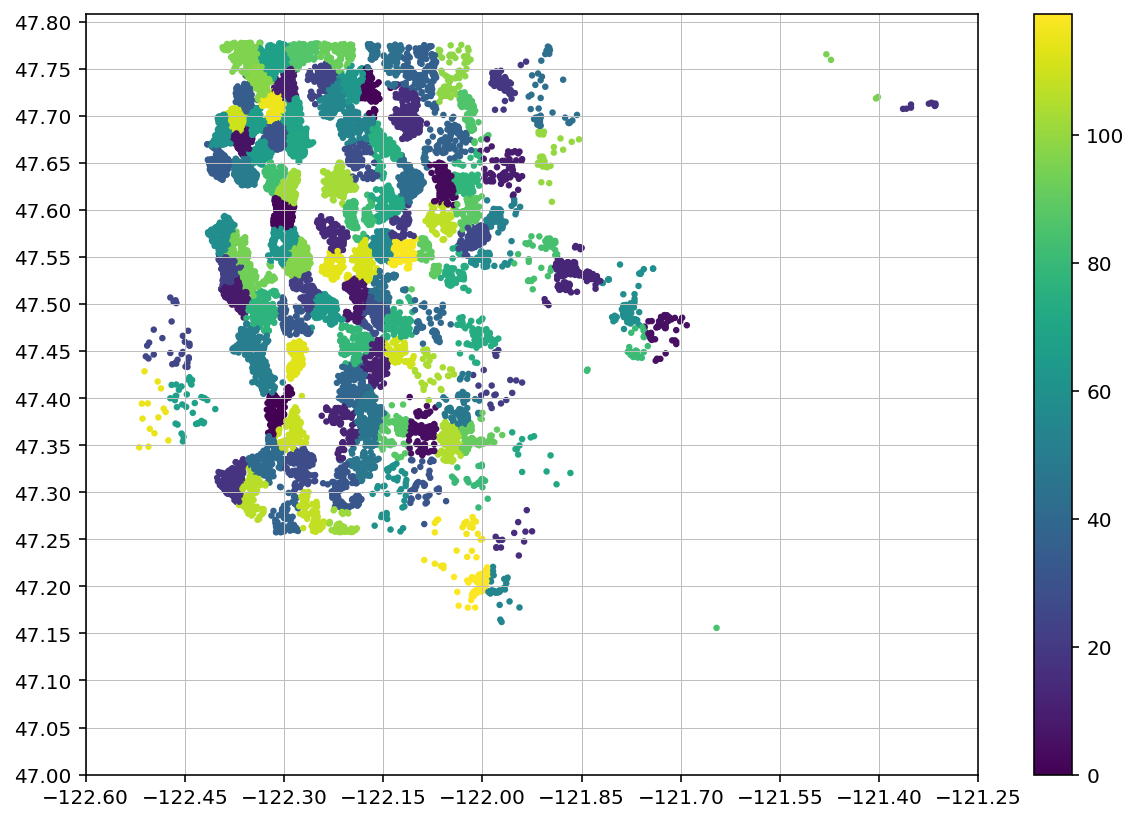

In [32]:
plt.figure(figsize=(10,7))
plt.scatter(X_train['long'], X_train['lat'], s=5, c=X_train['km_120'])
plt.yticks(np.arange(47, 47.81, 0.05))
plt.xticks(np.arange(-122.6, -121.2, 0.15))
plt.grid(color='#BDBDBD', linestyle='-', linewidth=0.5)
plt.colorbar()

- 120개의 군집을 통해 나눠본 후 
- 그리고 이를 바탕으로 km120과 price를 kmeans 후 X_test에 km120 기준으로 merge를 해보았습니다

In [33]:
X_train.drop('price', 1, inplace=True)

### 모델 설계 

모델은 ligt_GBM와 XGB의 앙상블을 선택하였습니다. 

In [34]:
%%time
dtrain = lgb.Dataset(X_train, label=y_train)
dtest  = lgb.Dataset(X_test)

lgb_params = {
    'boosting_type': 'gbdt',
    'objective':'regression',
    'num_leave' : 1,
    'learning_rate' : 0.03,
    'max_depth' : 6,
    'colsample_bytree' : 0.4,
    'subsample' : 0.4,
    'max_bin' : 80,
    'gpu_id':0,         
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'refit':True,
    'metric' : 'rmse',
    'seed' : 2019
}

cv_lgb_output = lgb.cv(lgb_params, dtrain, num_boost_round=5000, nfold=5, early_stopping_rounds=200, verbose_eval=100,stratified=False)

print('best_num_rounds :',len(cv_lgb_output['rmse-mean']))
print('best_cv_score :', cv_lgb_output['rmse-mean'][-1])

best_num_rounds = len(cv_lgb_output['rmse-mean'])

model_lgb = lgb.train(lgb_params, dtrain, num_boost_round=best_num_rounds)
lgb_pred_log = model_lgb.predict(X_test)
lgb_pred = np.expm1(lgb_pred_log)


[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	cv_agg's rmse: 0.159799 + 0.00150714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	cv_agg's rmse: 0.158025 + 0.00143759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[800]	cv_agg's rmse: 0.155713 + 0.0014367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	cv_agg's rmse: 0.15

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[1500]	cv_agg's rmse: 0.155199 + 0.00167105

best_num_rounds : 1328
best_cv_score : 0.15511974348944602
의 결과를 얻었습니다.

[11:48:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:48:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:48:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:48:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindi

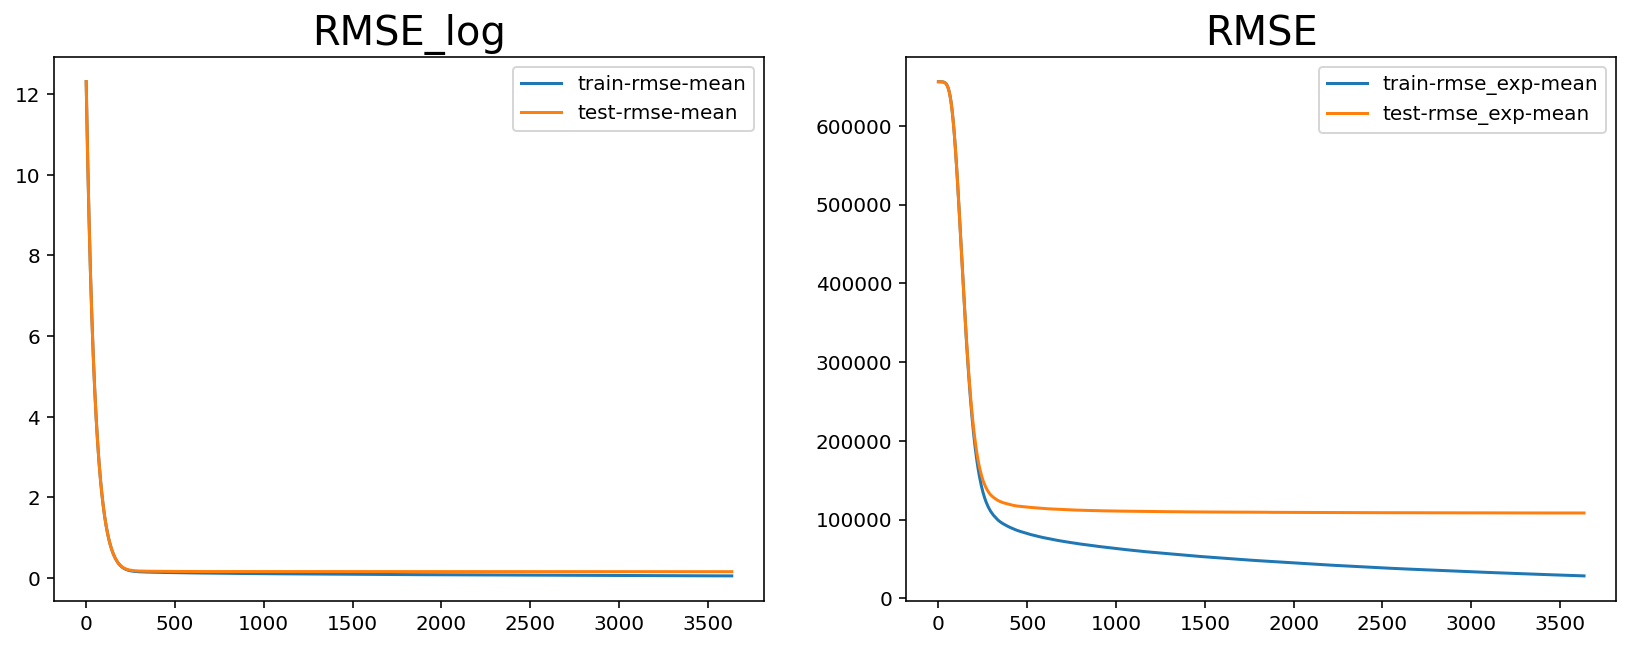

In [35]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',        
    'silent': True,               
    'seed' : 1984
}



# transform
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

# cross validation
cv_output = xgb.cv(xgb_params,
                   dtrain,                        
                   num_boost_round=5000,         
                   early_stopping_rounds=150,    
                   nfold=5,                      
                   verbose_eval=100,             
                   feval=rmse_exp,               
                   maximize=False,
                   show_stdv=False,              
                   )

# scoring
best_rounds = cv_output.index.size
score = round(cv_output.iloc[-1]['test-rmse_exp-mean'], 2)

print(f'\nBest Rounds: {best_rounds}')
print(f'Best Score: {score}')

model = xgb.train(xgb_params, dtrain, num_boost_round=best_rounds)
xgb_pred_log = model.predict(dtest)
xgb_pred = np.expm1(xgb_pred_log)

# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot(ax=ax1)
ax1.set_title('RMSE_log', fontsize=20)
cv_output[['train-rmse_exp-mean', 'test-rmse_exp-mean']].plot(ax=ax2)
ax2.set_title('RMSE', fontsize=20)

plt.show()


## Submission file 제출 

In [36]:
ensemble_pred = np.vstack([lgb_pred, xgb_pred]).mean(0)
sample_submission = pd.read_csv(data_dir + '/sample_submission.csv')
submission = pd.DataFrame(data = {'id': sub_id, 'price': ensemble_pred})
submission.to_csv('submission_ensemble_2021_02_16_1149.csv', index=False)


Private Score는 105849.02297을 얻었습니다.

# 소고

뭔가 아직도 저는 여러 LightGBM이나 XGB같은 모델링을 짜는데 있어서 어려움이 많은것같습니다.
데이터를 가지고 전처리하는 것이나 피쳐 엔지니어링 코드를 보면 아 대충 이렇게 돌아가는거구나 하는 감이랄도 오는데
모델링 자체는 이게 어떤식으로 이렇게 혼합하는지 잘모르겠습니다.

이번 SSAC 해커톤에서도 전처리만 하다 끝냈는데 좀 더 빠르게 코드를 작성하는 법을 연습해야할 것 같습니다. 